# Spending Data Function #

In [90]:
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def get_spending_data(start_date, end_date, naics_code):
    # Define the API endpoint URL
    base_url = "https://api.usaspending.gov/api/v2/search/spending_by_category/naics/"

    url = f"{base_url}{naics_code}"

    agency_object = {
        "type": "awarding",  
        "tier": "toptier",   
        "name": "Department of Defense"  
    }
    
    # Construct the payload
    payload = {
        "filters": {
            "time_period": [
                {
                    "start_date": start_date,
                    "end_date": end_date
                }
            ],
            "naics_codes": {
                "require": [naics_code]
            },
            "agencies": [agency_object]
        },
        "category": "naics",
        "limit": 5,
        "page": 1
    }

    # Make the API request
    response = requests.post(url, json=payload)

    if response.status_code == 200:
        data = response.json()
        return data
    else:
        print(f"Failed to retrieve data. Status code: {response.status_code}")
        return None
    
def annual_spending_range(start_year, end_year, naics_code):
    annual_spending = {}

    for year in range(start_year, end_year):
        start_date = f"{year}-01-01"
        end_date = f"{year + 1}-01-01"  

        result = get_spending_data(start_date, end_date, naics_code)
        
        if result and 'results' in result and len(result['results']) > 0:
            annual_spending[year] = result['results'][0]['amount']
        else:
            annual_spending[year] = 0

    return annual_spending

def plot_annual_spending(start_year, end_year, naics_code):
    
    data = annual_spending_range(start_year, end_year, naics_code)

    years = list(data.keys())
    amounts = list(data.values())
    df = pd.DataFrame({'Year': years, 'Amount': amounts})

    sns.set(style="whitegrid")
    plt.figure(figsize=(12, 6))
    ax = ax = sns.barplot(x="Year", y="Amount", hue="Amount", data=df, palette="Blues_d", legend=False)

    plt.xlabel('Year')
    plt.ylabel('Amount')
    title = f'NAICS Code {naics_code} Spending Over the Years'
    plt.title(title)

    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=9, color='black', xytext=(0, 10), textcoords='offset points')

    plt.show()

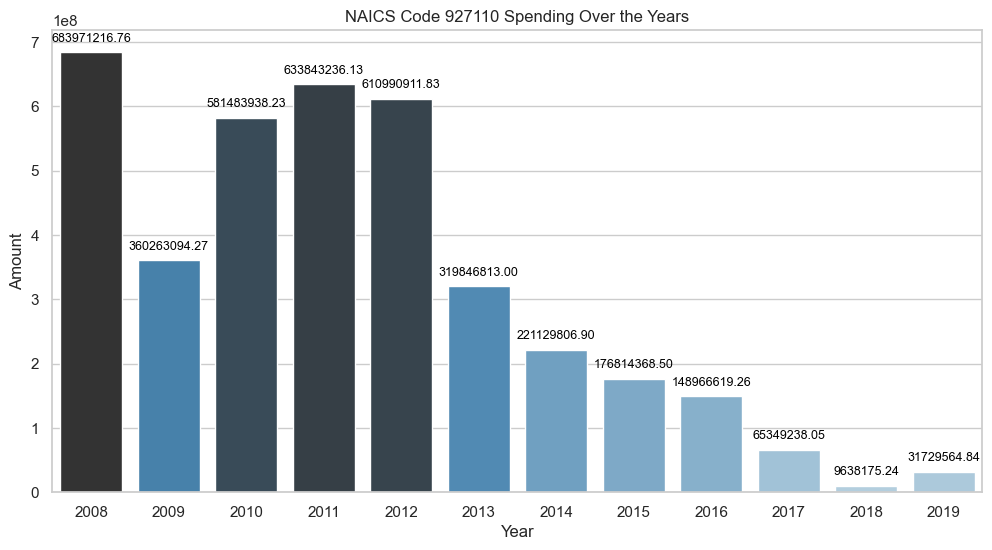

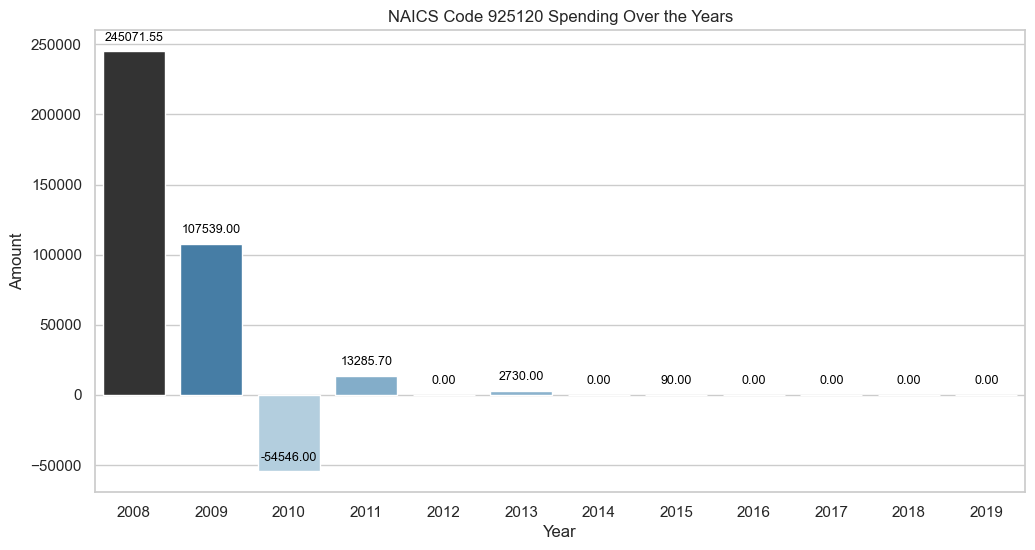

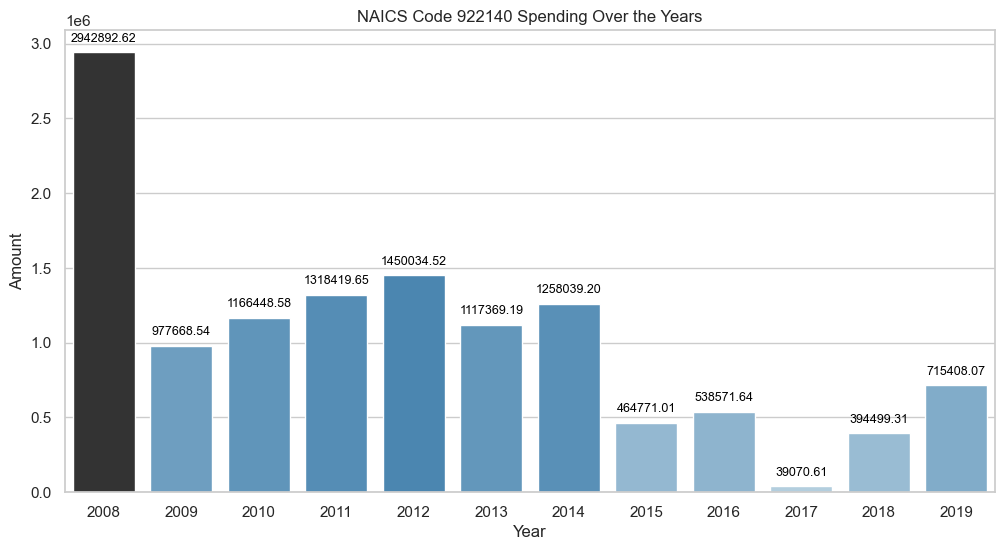

In [91]:
plot_annual_spending(2008, 2020, "927110")
plot_annual_spending(2008, 2020, "925120")
plot_annual_spending(2008, 2020, "922140")

In [92]:
# import requests
# import pandas as pd

# def fetch_contract_data(year):
#     url = 'https://api.usaspending.gov/api/v2/search/spending_by_award/'
#     params = {
#         "filters": {
#             "time_period": [{"start_date": f"{year}-10-01", "end_date": f"{year}-09-30"}],
#             "naics_codes": ["927110"],
#             "award_type_codes": ["C"]
#         },
#         "fields": ["Award Amount"],
#         "limit": 100,
#         "page": 1
#     }
#     response = requests.post(url, json=params)
#     response.raise_for_status()
#     return response.json()

# def get_yearly_contract_values():
#     years = range(2008, 2023) 
#     contract_values = {}
#     for year in years:
#         data = fetch_contract_data(year)
#         total_value = sum(item['Award Amount'] for item in data['results'])
#         contract_values[year] = total_value
#     return contract_values

# if __name__ == "__main__":
#     contract_values = get_yearly_contract_values()
#     df = pd.DataFrame(list(contract_values.items()), columns=["Year", "Total Contract Value"])
#     print(df)

In [102]:
import requests

def fetch_highest_contract(year, naics_code):
    url = 'https://api.usaspending.gov/api/v2/search/spending_by_award/'
    params = {
        "filters": {
            "time_period": [{"start_date": f"{year}-10-01", "end_date": f"{year+1}-09-30"}],
            "naics_codes": [naics_code],
            "award_type_codes": ["C"]
        },
        "fields": ["Award Amount", "Recipient Name"],
        "limit": 100,  # Adjust this value based on the total number of awards
        "page": 1,
        "order": "desc",
        "sort": "Award Amount"
    }
    response = requests.post(url, json=params)
    response.raise_for_status()
    result = response.json()
    if result['results']:
        highest_contract = result['results'][0]
        return highest_contract
    else:
        return None

def get_highest_contracts(naics_code):
    years = range(2008, 2023)  # Adjust the year range as needed
    highest_contracts = {}
    for year in years:
        highest_contract = fetch_highest_contract(year, naics_code)
        if highest_contract:
            highest_contracts[year] = highest_contract
    return highest_contracts

def plot_largest_contracts(contracts_dict, naics_code):
    years = list(contracts_dict.keys())
    highest_contracts = [float(item['Award Amount']) for item in contracts_dict.values()]
    df = pd.DataFrame({'Year': years, 'Highest Contract Value': highest_contracts})

    sns.set(style="whitegrid")
    plt.figure(figsize=(15, 6))
    ax = sns.barplot(x="Year", y="Highest Contract Value", hue="Highest Contract Value", data=df, palette="Blues_d", legend=False)

    plt.xlabel('Year')
    plt.ylabel('Highest Contract Value')
    title = f'NAICS Code {naics_code} Spending Over the Years'
    plt.title(title)

    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=9, color='black', xytext=(0, 10), textcoords='offset points')

    plt.show()

Year 2008: Highest Contract Value - $14217673.7, Company - THE AEROSPACE CORPORATION
Year 2009: Highest Contract Value - $18000000.0, Company - THE AEROSPACE CORPORATION
Year 2010: Highest Contract Value - $18000000.0, Company - THE AEROSPACE CORPORATION
Year 2011: Highest Contract Value - $14217673.7, Company - THE AEROSPACE CORPORATION
Year 2012: Highest Contract Value - $14217673.7, Company - THE AEROSPACE CORPORATION
Year 2013: Highest Contract Value - $14217673.7, Company - THE AEROSPACE CORPORATION
Year 2014: Highest Contract Value - $7945511.31, Company - THE AEROSPACE CORPORATION
Year 2015: Highest Contract Value - $7945511.31, Company - THE AEROSPACE CORPORATION
Year 2016: Highest Contract Value - $5532548.52, Company - THE AEROSPACE CORPORATION
Year 2017: Highest Contract Value - $653009.03, Company - THE AEROSPACE CORPORATION
Year 2018: Highest Contract Value - $653009.03, Company - THE AEROSPACE CORPORATION
Year 2019: Highest Contract Value - $457106.0, Company - MDA SYSTEM

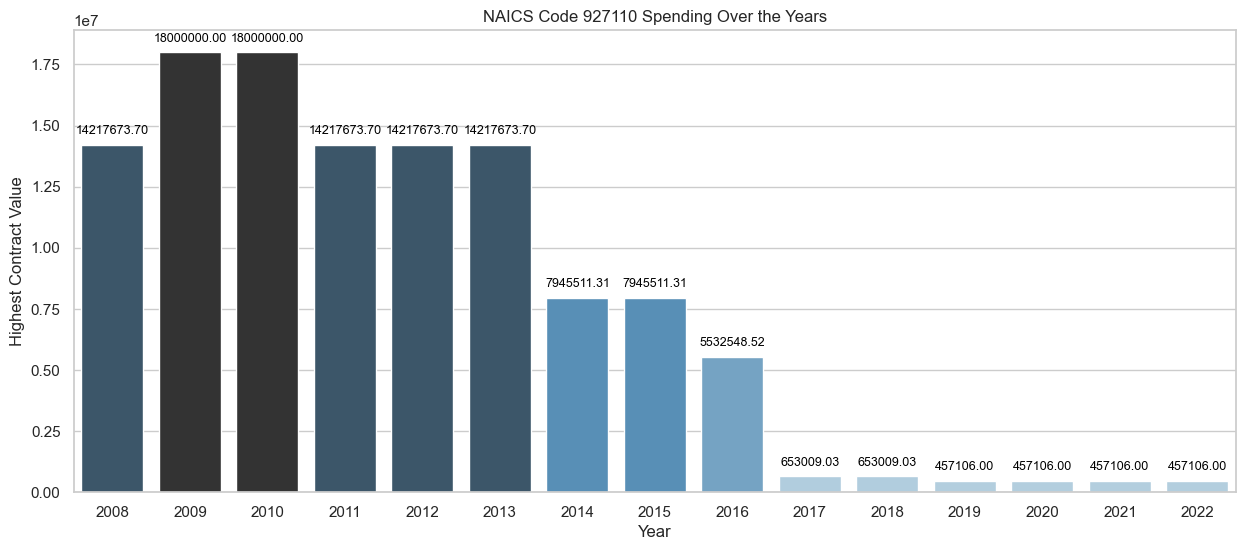

In [103]:
if __name__ == "__main__":
    highest_contracts_927110 = get_highest_contracts("927110")
    for year, contract in highest_contracts_927110.items():
        print(f"Year {year}: Highest Contract Value - ${contract['Award Amount']}, Company - {contract['Recipient Name']}")
    plot_largest_contracts(highest_contracts_927110, "927110")

Year 2008: Highest Contract Value - $2773748.03, Company - COORDINATION AND PLANNING PARTNERS
Year 2009: Highest Contract Value - $2773748.03, Company - COORDINATION AND PLANNING PARTNERS
Year 2010: Highest Contract Value - $2773748.03, Company - COORDINATION AND PLANNING PARTNERS
Year 2011: Highest Contract Value - $2773748.03, Company - COORDINATION AND PLANNING PARTNERS
Year 2012: Highest Contract Value - $2773748.03, Company - COORDINATION AND PLANNING PARTNERS
Year 2013: Highest Contract Value - $2773748.03, Company - COORDINATION AND PLANNING PARTNERS
Year 2014: Highest Contract Value - $2773748.03, Company - COORDINATION AND PLANNING PARTNERS
Year 2015: Highest Contract Value - $2773748.03, Company - COORDINATION AND PLANNING PARTNERS
Year 2016: Highest Contract Value - $1562200.41, Company - COORDINATION AND PLANNING PARTNERS
Year 2017: Highest Contract Value - $485738.94, Company - COORDINATION AND PLANNING PARTNERS
Year 2018: Highest Contract Value - $379000.0, Company - COOR

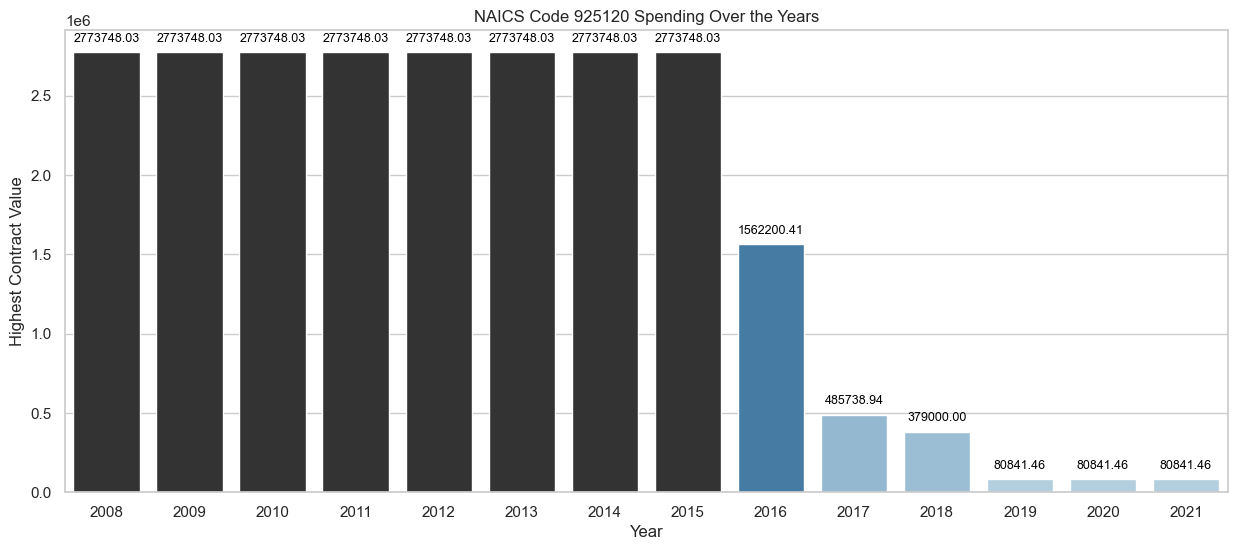

In [104]:
if __name__ == "__main__":
    highest_contracts_925120 = get_highest_contracts("925120")
    for year, contract in highest_contracts_925120.items():
        print(f"Year {year}: Highest Contract Value - ${contract['Award Amount']}, Company - {contract['Recipient Name']}")
    plot_largest_contracts(highest_contracts_925120, "925120")

Year 2008: Highest Contract Value - $17686395.68, Company - CORECIVIC, INC.
Year 2009: Highest Contract Value - $20943015.01, Company - CORECIVIC, INC.
Year 2010: Highest Contract Value - $20943015.01, Company - CORECIVIC, INC.
Year 2011: Highest Contract Value - $20943015.01, Company - CORECIVIC, INC.
Year 2012: Highest Contract Value - $20943015.01, Company - CORECIVIC, INC.
Year 2013: Highest Contract Value - $20943015.01, Company - CORECIVIC, INC.
Year 2014: Highest Contract Value - $20943015.01, Company - CORECIVIC, INC.
Year 2015: Highest Contract Value - $20943015.01, Company - CORECIVIC, INC.
Year 2016: Highest Contract Value - $20943015.01, Company - CORECIVIC, INC.
Year 2017: Highest Contract Value - $12799093.62, Company - CORECIVIC, INC.
Year 2018: Highest Contract Value - $12799093.62, Company - CORECIVIC, INC.
Year 2019: Highest Contract Value - $51996947.54, Company - GEO GROUP, INC., THE
Year 2020: Highest Contract Value - $52818941.99, Company - GEO GROUP, INC., THE
Ye

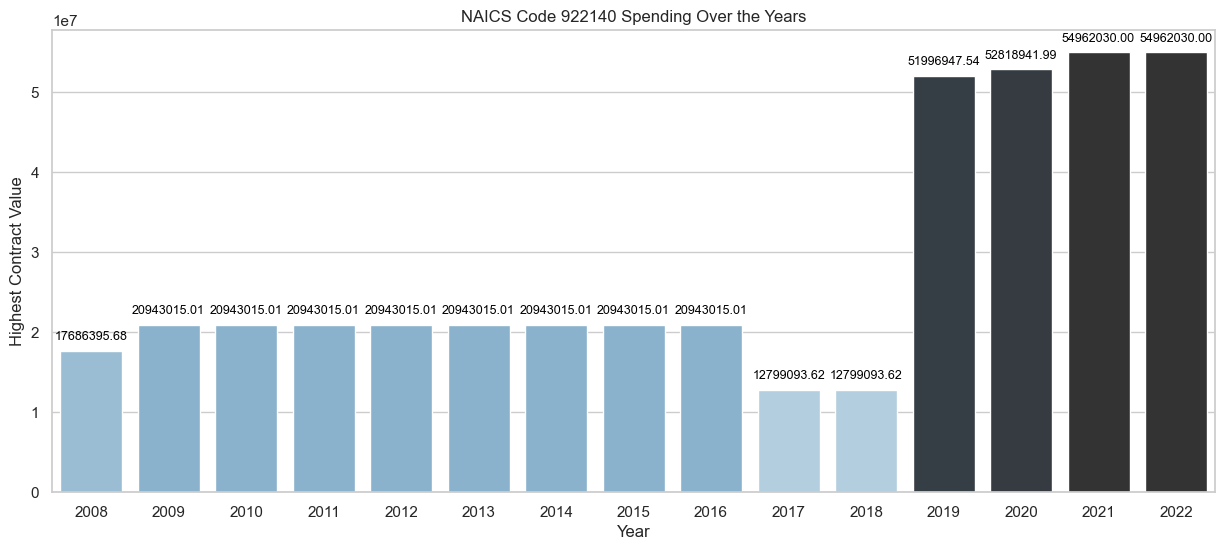

In [105]:
if __name__ == "__main__":
    highest_contracts_922140 = get_highest_contracts("922140")
    for year, contract in highest_contracts_922140.items():
        print(f"Year {year}: Highest Contract Value - ${contract['Award Amount']}, Company - {contract['Recipient Name']}")
    plot_largest_contracts(highest_contracts_922140, "922140")